In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

from neuralnetlib.preprocessing import MinMaxScaler
from neuralnetlib.models import Sequential, GAN
from neuralnetlib.layers import Input, Dense, BatchNormalization, Dropout, Activation
from neuralnetlib.activations import LeakyReLU
from neuralnetlib.optimizers import Adam
from neuralnetlib.losses import Wasserstein

In [2]:
print("Loading MNIST dataset...")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X = X.astype('float32')

Loading MNIST dataset...


In [3]:
dim = X.shape[1]

scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X)
X_reshaped = X_scaled.reshape(-1, dim)

latent_dim = 100

In [4]:
generator = Sequential(random_state=42)

generator.add(Input(latent_dim))

generator.add(Dense(256))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(alpha=0.2)))

generator.add(Dense(512))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(alpha=0.2)))

generator.add(Dense(1024))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(alpha=0.2)))

generator.add(Dense(dim, activation='tanh'))

In [5]:
discriminator = Sequential(random_state=42)

discriminator.add(Input(dim))

discriminator.add(Dense(128, input_dim=dim))
discriminator.add(Activation(LeakyReLU(alpha=0.4)))
discriminator.add(Dropout(0.6))

discriminator.add(Dense(64))
discriminator.add(Activation(LeakyReLU(alpha=0.4)))
discriminator.add(Dropout(0.6))

discriminator.add(Dense(1, activation='linear'))

In [6]:
gan = GAN(latent_dim=latent_dim)

gan.compile(
    generator,
    discriminator,
    generator_optimizer=Adam(learning_rate=0.001),
    discriminator_optimizer=Adam(learning_rate=0.0001),
    loss_function='wass',
    verbose=True
)

GAN(latent_dim=100, gradient_clip_threshold=0.1, enable_padding=False, padding_size=32, random_state=1732538869498774500)
-------------------------------------------------
Generator:
Sequential(gradient_clip_threshold=5.0, enable_padding=False, padding_size=32, random_state=42)
-------------------------------------------------
Layer 1: Input(input_shape=(100,))
Layer 2: Dense(units=256)
Layer 3: BatchNormalization(momentum=0.9, epsilon=1e-05)
Layer 4: Activation(LeakyReLU)
Layer 5: Dense(units=512)
Layer 6: BatchNormalization(momentum=0.9, epsilon=1e-05)
Layer 7: Activation(LeakyReLU)
Layer 8: Dense(units=1024)
Layer 9: BatchNormalization(momentum=0.9, epsilon=1e-05)
Layer 10: Activation(LeakyReLU)
Layer 11: Dense(units=784)
Layer 12: Activation(Tanh)
-------------------------------------------------
Loss function: Wasserstein
Optimizer: Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, clip_norm=None, clip_value=None)
-------------------------------------------------


In [7]:
epochs = 100
batch_size = 128

history = gan.fit(
    X_reshaped,
    epochs=epochs,
    batch_size=batch_size,
    verbose=True,
    metrics=['mmd']
)

[==============================] 100% Epoch 1/100 - d_loss: 25.7920 - g_loss: -6.7792 - mmd: 0.3347 - 94.06s.80sssss11s3.66s
[==============================] 100% Epoch 2/100 - d_loss: 27.3240 - g_loss: -8.0737 - mmd: 0.3565 - 85.86s
[==============================] 100% Epoch 3/100 - d_loss: 26.4827 - g_loss: -8.7352 - mmd: 0.6290 - 86.68s
[==============================] 100% Epoch 4/100 - d_loss: 25.6289 - g_loss: -9.1887 - mmd: 0.6307 - 82.56s
[==============================] 100% Epoch 5/100 - d_loss: 24.4155 - g_loss: -9.1873 - mmd: 0.6314 - 90.40s
[==============================] 100% Epoch 6/100 - d_loss: 23.1794 - g_loss: -8.5898 - mmd: 0.6319 - 86.55s
[===---------------------------] 11% Epoch 7/100 - d_loss: 23.0789 - g_loss: -7.5182 - mmd: 0.6128 - 9.87s

KeyboardInterrupt: 

C:\Users\marcp\AppData\Local\Temp\ipykernel_21064\3687687509.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n_rows, n_cols*2, idx*2 + 1)


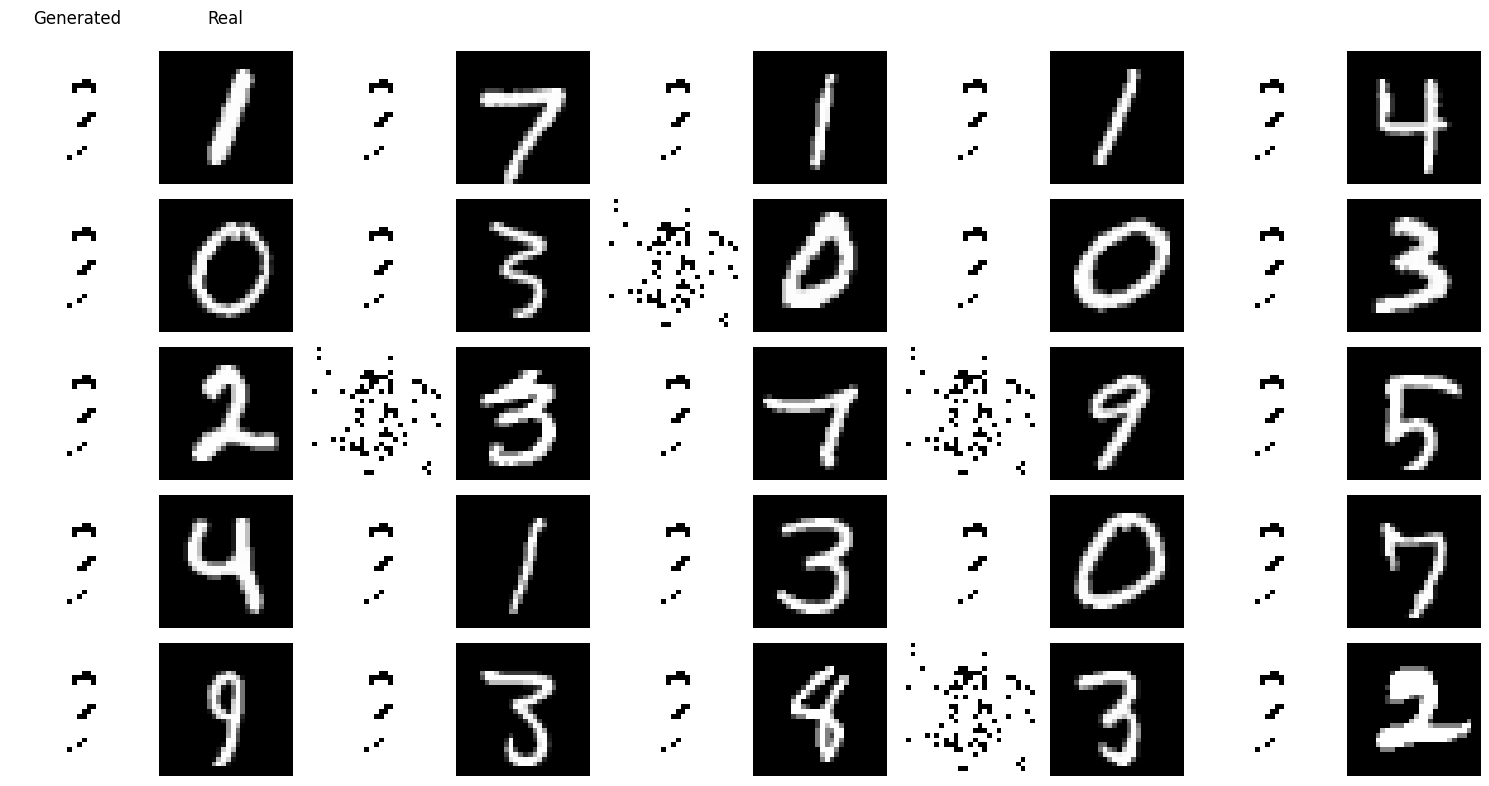

In [8]:
def visualize_mnist_samples(gan_model, n_samples=25, n_cols=5):
    n_rows = n_samples // n_cols
    plt.figure(figsize=(15, 8))

    generated_samples = gan_model.predict(n_samples)
    
    generated_samples = (generated_samples + 1) / 2
    
    rng = np.random.default_rng(42)
    real_indices = rng.integers(0, X_reshaped.shape[0], n_samples)
    real_samples = (X_reshaped[real_indices] + 1) / 2

    plt.subplot(1, 2, 1)
    for idx in range(n_samples):
        plt.subplot(n_rows, n_cols*2, idx*2 + 1)
        plt.imshow(generated_samples[idx].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if idx % n_cols == 0:
            if idx == 0:
                plt.title('Generated', pad=20)
        
        plt.subplot(n_rows, n_cols*2, idx*2 + 2)
        plt.imshow(real_samples[idx].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if idx % n_cols == 0:
            if idx == 0:
                plt.title('Real', pad=20)

    plt.tight_layout()
    plt.show()

visualize_mnist_samples(gan)